# Multi-Armed Bandit (MAB)
It is a reinforcement learning problem where an agent selects actions repeatedly to maximize cumulative reward.
Each action (arm) provides an immediate reward from an unknown distribution.
The agent must balance exploration (trying new actions) and exploitation (choosing the best-known action).
MAB problems have no state transitions or delayed rewards.
They are commonly used in recommendation systems, online advertising, and decision-making under uncertainty.

### Data Loading and Libraries

This cell imports the required libraries and loads the product
recommendation dataset.

The dataset contains user-wise product rewards and associated costs,
which are used to compute net rewards for decision-making.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


### Dataset Structure

This cell verifies the column structure of the dataset to ensure
correct feature naming and access during further analysis.


In [5]:
df = pd.read_csv(r"C:\Users\hcldr\Downloads\Dataset_Product_Recommendation.csv")
df.head()

,User_ID,Product 1,cost 1,Product 2,cost 2,Product 3,cost 3,Product 4,cost 4,Product 5,cost 5,Product 6,cost 6
0,1,8.308075,0.118582,71.868439,4.032662,41.858863,10.259441,24.726454,15.071291,2.508992,19.966871,60.703456,22.545958
1,2,9.040232,1.276014,71.551909,4.893586,40.684587,9.183102,23.554125,14.188975,2.803275,19.766006,59.838882,22.771789
2,3,8.405164,2.573752,72.221606,5.201210,43.586272,10.972955,24.572589,14.177388,3.028663,20.104219,58.512739,22.247714
3,4,9.247704,1.375703,71.218781,4.120079,40.883604,10.480112,24.572818,15.133472,3.193420,20.347757,58.694852,22.659512
4,5,9.144098,-0.401791,71.275463,5.032439,40.145258,10.448089,23.401485,16.027929,3.466858,19.476062,59.009021,23.302446


In [9]:
df.shape 


(498, 13)

### Net Reward Calculation

Net reward is computed as the difference between the product reward
and its associated cost.

This represents the actual profit obtained by recommending a product.


In [15]:
# Compute net reward for each product (FIXED for actual column names)
for i in range(1, 7):
    df[f'net_{i}'] = df[f'Product {i}'] - df[f'cost {i}']

df[[f'net_{i}' for i in range(1, 7)]].head()



,net_1,net_2,net_3,net_4,net_5,net_6
0,8.189493,67.835777,31.599422,9.655163,-17.457879,38.157498
1,7.764218,66.658323,31.501485,9.365150,-16.962731,37.067093
2,5.831412,67.020396,32.613317,10.395201,-17.075556,36.265025
3,7.872001,67.098702,30.403492,9.439346,-17.154337,36.035340
4,9.545889,66.243024,29.697169,7.373556,-16.009204,35.706575


In [17]:
print(df.columns)


Index(['User_ID', 'Product 1', 'cost 1', 'Product 2', 'cost 2', 'Product 3',
       'cost 3', 'Product 4', 'cost 4', 'Product 5', 'cost 5', 'Product 6',
       'cost 6', 'net_1', 'net_2', 'net_3', 'net_4', 'net_5', 'net_6'],
      dtype='object')


### Statistical Analysis of Products

The mean net reward and number of negative outcomes are computed
for each product to understand baseline profitability and risk.


In [19]:
mean_rewards = {}
negative_counts = {}

for i in range(1, 7):
    mean_rewards[f'Product{i}'] = df[f'net_{i}'].mean()
    negative_counts[f'Product{i}'] = (df[f'net_{i}'] < 0).sum()

print("Mean Net Reward per Product:")
for k, v in mean_rewards.items():
    print(k, ":", v)

print("\nNegative Reward Counts:")
for k, v in negative_counts.items():
    print(k, ":", v)


Mean Net Reward per Product:
Product1 : 7.062783928915663
Product2 : 66.99299488915662
Product3 : 31.41845221807229
Product4 : 9.596788977510041
Product5 : -17.064884026104416
Product6 : 36.986031226907635

Negative Reward Counts:
Product1 : 0
Product2 : 0
Product3 : 0
Product4 : 0
Product5 : 498
Product6 : 0


### Random Policy Baseline

A random policy selects products uniformly at random.

This serves as a baseline strategy to evaluate the effectiveness
of learning-based approaches.


In [21]:
rounds = 300
random_rewards = []

for _ in range(rounds):
    user = random.randint(0, len(df) - 1)
    product = random.randint(1, 6)
    reward = df.loc[user, f'net_{product}']
    random_rewards.append(reward)

random_rewards = np.array(random_rewards)

print("Random Policy:")
print("Average profit per round:", random_rewards.mean())
print("Total profit:", random_rewards.sum())


Random Policy:
Average profit per round: 22.61306975533333
Total profit: 6783.9209266


### Random Policy Performance Visualization

This plot shows the cumulative net profit obtained using the
random policy across multiple rounds.


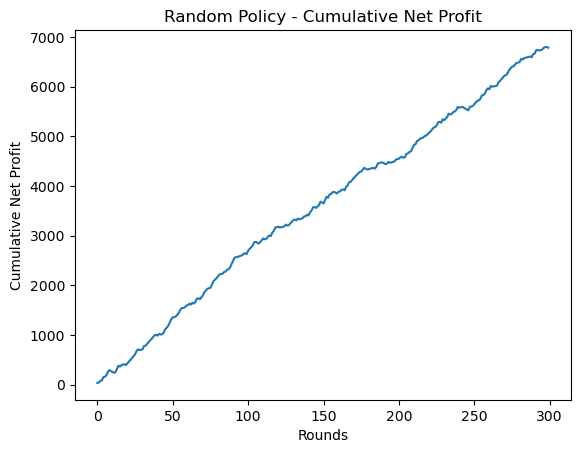

In [23]:
plt.figure()
plt.plot(np.cumsum(random_rewards))
plt.title("Random Policy - Cumulative Net Profit")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Net Profit")
plt.show()


### Initial Exploration Phase

Each product is sampled a fixed number of times to estimate
initial mean rewards before applying the greedy strategy.


In [25]:
initial_trials = 10
product_means = {}

for p in range(1, 7):
    rewards = []
    for _ in range(initial_trials):
        user = random.randint(0, len(df) - 1)
        rewards.append(df.loc[user, f'net_{p}'])
    product_means[p] = np.mean(rewards)

print("Estimated Mean Reward after Initial Trials:")
product_means


Estimated Mean Reward after Initial Trials:


{1: 7.303977859999999,
 2: 66.65211511999999,
 3: 31.5609909,
 4: 9.395333400000002,
 5: -16.88415326,
 6: 36.932120000000005}

### Greedy Strategy

The greedy strategy always selects the product with the highest
estimated mean reward, prioritizing exploitation over exploration.


In [27]:
best_product = max(product_means, key=product_means.get)
print("Best Product Chosen:", best_product)

greedy_rewards = []

for _ in range(rounds):
    user = random.randint(0, len(df) - 1)
    greedy_rewards.append(df.loc[user, f'net_{best_product}'])

greedy_rewards = np.array(greedy_rewards)

print("Greedy Strategy Total Profit:", greedy_rewards.sum())


Best Product Chosen: 2
Greedy Strategy Total Profit: 20095.566296


### ε-Greedy Strategy Implementation

The ε-greedy algorithm balances exploration and exploitation
by choosing a random action with probability ε and the best-known
action otherwise.


In [29]:
def epsilon_greedy(epsilon, rounds=300):
    estimates = np.zeros(6)
    counts = np.zeros(6)
    rewards = []
    selections = np.zeros(6)

    for _ in range(rounds):
        user = random.randint(0, len(df) - 1)

        if random.random() < epsilon:
            product = random.randint(1, 6)
        else:
            product = np.argmax(estimates) + 1

        reward = df.loc[user, f'net_{product}']
        rewards.append(reward)

        idx = product - 1
        selections[idx] += 1
        counts[idx] += 1
        estimates[idx] += (reward - estimates[idx]) / counts[idx]

    return np.array(rewards), selections


### ε-Greedy Experiments

The ε-greedy strategy is evaluated using different ε values
to study the impact of exploration on cumulative reward.


In [32]:
epsilons = [0.02, 0.10, 0.25]
results = {}
selection_counts = {}

for e in epsilons:
    rewards, selections = epsilon_greedy(e)
    results[e] = rewards
    selection_counts[e] = selections

    print(f"\nEpsilon = {e}")
    print("Total Profit:", rewards.sum())
    print("Selections:", selections)



Epsilon = 0.02
Total Profit: 6936.417928200001
Selections: [ 19.  71.   0. 209.   0.   1.]

Epsilon = 0.1
Total Profit: 18543.9575614
Selections: [ 12. 269.   6.   7.   1.   5.]

Epsilon = 0.25
Total Profit: 15104.605625000002
Selections: [ 10. 174.  17.  14.   8.  77.]


### ε-Greedy Performance Comparison

This plot compares cumulative rewards obtained under different
ε values to analyze strategy effectiveness.


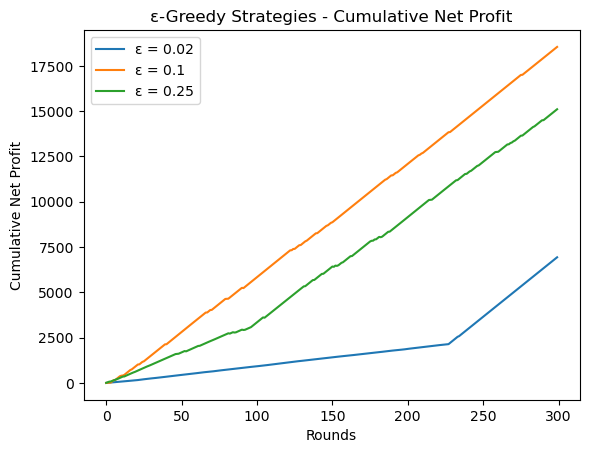

In [34]:
plt.figure()
for e in epsilons:
    plt.plot(np.cumsum(results[e]), label=f"ε = {e}")

plt.title("ε-Greedy Strategies - Cumulative Net Profit")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Net Profit")
plt.legend()
plt.show()


### Comparison of All Strategies

This visualization compares Random, Greedy, and ε-Greedy strategies,
highlighting the trade-off between exploration and exploitation.


In [36]:
for e in epsilons:
    print(f"\nEpsilon = {e}")
    for i in range(6):
        print(f"Product {i+1}: selected {int(selection_counts[e][i])} times")



Epsilon = 0.02
Product 1: selected 19 times
Product 2: selected 71 times
Product 3: selected 0 times
Product 4: selected 209 times
Product 5: selected 0 times
Product 6: selected 1 times

Epsilon = 0.1
Product 1: selected 12 times
Product 2: selected 269 times
Product 3: selected 6 times
Product 4: selected 7 times
Product 5: selected 1 times
Product 6: selected 5 times

Epsilon = 0.25
Product 1: selected 10 times
Product 2: selected 174 times
Product 3: selected 17 times
Product 4: selected 14 times
Product 5: selected 8 times
Product 6: selected 77 times


### Discussion

The ε-greedy strategy achieves better performance than purely random
or greedy approaches by maintaining an optimal balance between
exploration and exploitation.


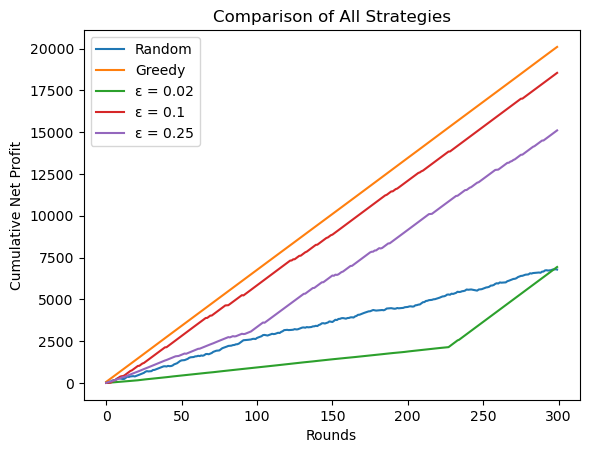

In [38]:
plt.figure()
plt.plot(np.cumsum(random_rewards), label="Random")
plt.plot(np.cumsum(greedy_rewards), label="Greedy")

for e in epsilons:
    plt.plot(np.cumsum(results[e]), label=f"ε = {e}")

plt.title("Comparison of All Strategies")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Net Profit")
plt.legend()
plt.show()
